<a href="https://colab.research.google.com/github/jayantc14/News-Classification/blob/main/CNNFakenewsTensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import scale

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/IIM/data")

In [ ]:
df.drop(['Unnamed: 0'],axis = 1,inplace  = True)

In [ ]:
df

,Analytic,Authentic,Tone,WPS,Sixltr,number,quant,posemo,negemo,tentat,certain,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,FREScore,target
0,97.02,22.27,35.07,23.41,28.44,2.80,1.34,1.60,1.07,1.20,0.27,1.20,5.87,0.80,0.93,4.01,6.81,2.00,42.04,1
1,96.86,13.98,49.52,20.23,32.85,2.39,1.28,2.71,1.44,0.96,0.48,0.96,8.61,0.80,1.12,3.83,5.10,2.07,32.57,1
2,94.73,16.26,29.43,24.05,27.35,0.88,1.75,1.09,0.88,3.94,0.66,0.66,6.13,0.44,0.00,5.47,5.47,1.97,39.91,1
3,96.40,12.12,55.62,22.29,32.19,2.11,0.53,2.11,0.53,1.32,0.26,1.32,6.60,0.53,0.00,6.33,3.43,0.53,45.49,1
4,96.29,22.73,15.88,22.05,27.21,4.19,3.14,1.16,1.86,0.93,0.81,0.81,3.60,0.70,0.93,3.49,5.47,0.23,50.80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44873,96.34,16.74,46.26,49.00,28.01,1.11,2.04,3.90,2.78,2.60,0.93,0.74,3.15,0.93,0.37,5.19,3.71,0.37,22.35,0
44874,94.03,14.89,56.75,27.73,19.02,3.28,1.97,2.95,1.31,1.97,0.33,2.30,5.57,2.30,0.33,3.93,6.23,0.98,51.41,0
44875,90.88,33.24,22.15,38.88,22.66,1.59,1.99,2.48,2.71,2.22,1.54,1.68,4.68,0.77,1.03,2.83,5.94,1.52,28.24,0
44876,91.99,25.14,49.16,47.70,20.34,4.40,2.31,2.52,1.26,1.05,2.10,2.10,3.14,1.68,1.05,3.77,7.13,0.84,27.16,0


In [ ]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

28721 train examples
7181 validation examples
8976 test examples


In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  
  print('A batch of targets:', label_batch )

Every feature: ['Analytic', 'Authentic', 'Tone', 'WPS', 'Sixltr', 'number', 'quant', 'posemo', 'negemo', 'tentat', 'certain', 'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'FREScore']
A batch of targets: tf.Tensor([0 1 1 1 0], shape=(5,), dtype=int64)


In [ ]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

In [ ]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [ ]:
photo_count = feature_column.numeric_column('quant')
demo(photo_count)

[[1.93]
 [1.29]
 [0.  ]
 [1.44]
 [1.41]]


In [ ]:
feature_columns = []

# numeric cols
for header in ['Analytic', 'Authentic', 'Tone', 'WPS', 'Sixltr', 'number', 'quant', 'posemo', 'negemo', 'tentat', 'certain', 'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'FREScore']:
  feature_columns.append(feature_column.numeric_column(header))

In [ ]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [ ]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
884/898 [============================>.] - ETA: 0s - loss: 0.4180 - accuracy: 0.8406WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Analytic': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'Authentic': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'Tone': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'WPS': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=float64>, 'Sixltr': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'number': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=float64>, 'quant': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=float64>, 'posemo': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=float64>, 'negemo': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=float64>, 'tentat': <tf.Tensor 'ExpandDims_18:

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

281/281 [==============================] - 1s 2ms/step - loss: 0.2635 - accuracy: 0.8925
Accuracy 0.8924911022186279


In [ ]:
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
predicted = model.predict(X_test)

In [ ]:
print(metrics.confusion_matrix(y_test, predicted))

[[6327  730]
 [ 569 5838]]


In [ ]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      7057
           1       0.89      0.91      0.90      6407

    accuracy                           0.90     13464
   macro avg       0.90      0.90      0.90     13464
weighted avg       0.90      0.90      0.90     13464



In [ ]:
print(model.score(X_test,y_test))

0.9035204991087344


In [ ]:
from matplotlib import pyplot

Feature: 0, Score: 0.28037
Feature: 1, Score: 0.02999
Feature: 2, Score: 0.01616
Feature: 3, Score: 0.08011
Feature: 4, Score: 0.13580
Feature: 5, Score: 0.02910
Feature: 6, Score: 0.06972
Feature: 7, Score: 0.00729
Feature: 8, Score: 0.01988
Feature: 9, Score: 0.03163
Feature: 10, Score: 0.06949
Feature: 11, Score: 0.03174
Feature: 12, Score: 0.03996
Feature: 13, Score: 0.02159
Feature: 14, Score: 0.01274
Feature: 15, Score: 0.04637
Feature: 16, Score: 0.01136
Feature: 17, Score: 0.02749
Feature: 18, Score: 0.03920


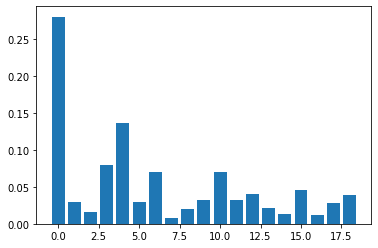

In [ ]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:

param_grid = {
    'max_depth': [5,8,10],
    'n_estimators': [50,100,150,],
    'learning_rate': [0.1, 0.01, 0.05],
    'subsample': [ 0.6, 1]
}

## **Hyperparameter Tuning**

In [ ]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 10

# specify range of hyperparameters
#param_grid = {'learning_rate': [0.1,0.5], 
             #'subsample': [ 0.6, 1]}          


# specify model
xgb_model = XGBClassifier()

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid,                          
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)   

In [ ]:
# fit the model
model_cv.fit(X_train, y_train)  

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 79.1min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [5, 8, 10],
                         'n_estimators': [50, 100, 150],
        

In [ ]:

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,2.587727,0.049830,0.012292,0.000856,0.1,5,50,0.6,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.913113,0.907384,0.914067,0.919796,0.909901,0.907036,0.913085,0.901942,0.913403,0.906399,0.910613,0.004828,36,0.924484,0.922998,0.922750,0.922892,0.922258,0.923142,0.923001,0.923708,0.922187,0.924981,0.923240,0.000858
1,2.222049,0.018294,0.011827,0.000087,0.1,5,50,1,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.909612,0.907702,0.914704,0.917250,0.909901,0.907673,0.908309,0.901624,0.910538,0.905444,0.909276,0.004176,37,0.925368,0.924590,0.923529,0.923741,0.924133,0.924380,0.923991,0.924026,0.923461,0.925441,0.924266,0.000658
2,4.961192,0.020051,0.021325,0.000246,0.1,5,100,0.6,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.915977,0.918523,0.922979,0.928071,0.921363,0.921044,0.917861,0.914358,0.921999,0.914358,0.919653,0.004079,24,0.938632,0.936863,0.937146,0.936580,0.937255,0.938599,0.938210,0.938599,0.937538,0.939200,0.937862,0.000849
3,4.270570,0.033783,0.021544,0.001028,0.1,5,100,1,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.917887,0.918205,0.922024,0.926798,0.921999,0.917224,0.914040,0.913403,0.918497,0.914040,0.918412,0.004016,26,0.939375,0.940153,0.938667,0.938137,0.938599,0.938705,0.938493,0.939660,0.939094,0.940438,0.939132,0.000719
4,7.240818,0.021867,0.030830,0.001285,0.1,5,150,0.6,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.919478,0.920751,0.924252,0.932209,0.923273,0.923591,0.923273,0.916905,0.925820,0.919134,0.922869,0.004052,17,0.946307,0.946555,0.946626,0.947156,0.946521,0.947689,0.946910,0.947618,0.946486,0.948042,0.946991,0.000573
5,6.139449,0.024851,0.030259,0.000930,0.1,5,150,1,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.918842,0.919796,0.922661,0.930617,0.923273,0.920408,0.918816,0.916905,0.923910,0.917861,0.921309,0.003818,20,0.947121,0.947333,0.946909,0.947156,0.947830,0.946804,0.947547,0.947936,0.947865,0.948396,0.947490,0.000486
6,4.769385,0.018682,0.017957,0.000202,0.1,8,50,0.6,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.919160,0.922024,0.925843,0.928071,0.920089,0.921044,0.920408,0.914040,0.920408,0.914995,0.920608,0.004030,23,0.958298,0.956883,0.959147,0.957520,0.957734,0.958370,0.957451,0.957486,0.956602,0.958158,0.957765,0.000713
7,4.437964,0.029723,0.017698,0.000182,0.1,8,50,1,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.921706,0.920751,0.923934,0.927753,0.920408,0.919134,0.921044,0.914677,0.925183,0.915314,0.920990,0.003853,21,0.964276,0.965160,0.964205,0.963780,0.963676,0.963393,0.963711,0.963004,0.963676,0.963852,0.963873,0.000550
8,9.079178,0.053835,0.033599,0.000849,0.1,8,100,0.6,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.926162,0.929981,0.935710,0.936346,0.927730,0.925501,0.929004,0.927730,0.928685,0.923910,0.929076,0.003866,9,0.979202,0.978282,0.977787,0.977257,0.978601,0.978389,0.979026,0.977576,0.977505,0.978495,0.978212,0.000625
9,8.168818,0.082902,0.033274,0.000835,0.1,8,100,1,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.925207,0.926798,0.934437,0.935391,0.931869,0.928685,0.927730,0.922954,0.931869,0.922636,0.928758,0.004293,10,0.981926,0.982315,0.979202,0.981324,0.981785,0.979203,0.980688,0.979663,0.979592,0.981749,0.980745,0.001164


In [ ]:
model_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150, 'subsample': 1}

In [ ]:
# chosen hyperparameters

params = {'learning_rate': 0.1,
           'max_depth': 10,
          'subsample':1,
          'n_estimators': 150
         }

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.1, 'max_depth': 10,
                      'n_estimators': 150, 'subsample': 1},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
predicted = model.predict(X_test)

In [ ]:
print(metrics.confusion_matrix(y_test, predicted))

[[6327  730]
 [ 569 5838]]


In [ ]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      7057
           1       0.89      0.91      0.90      6407

    accuracy                           0.90     13464
   macro avg       0.90      0.90      0.90     13464
weighted avg       0.90      0.90      0.90     13464



In [ ]:
print(model.score(X_test,y_test))

0.9035204991087344
